In [6]:
import pandas as pd

# Загрузка обучающего датасета
df = pd.read_excel("data/Data_Set_(A+B).xlsx")

# Проверим первые строки
df.head()

,I1,I2,I3,gx,gy,gz,ax,ay,az,V1real,V2real,V3real,N1,N2,N3,Type
0,1.126697,0.021116,0.927601,0.712941,-0.252941,1.081765,0.043529,0.003174,0.011661,-249.352941,4.764706,265.235294,-5070,30,5239,1
1,1.039215,0.015083,0.953243,0.229412,0.276471,0.485294,0.013672,-0.005572,0.012164,-260.470588,0.000000,263.647059,-5320,-9,5391,1
2,0.911011,0.004525,0.947210,1.170588,0.222941,0.664118,0.011704,0.003720,0.005744,-268.411765,0.000000,268.411765,-4829,6,4786,1
3,0.692308,1.156862,0.550528,1.165294,0.698235,-3.421765,0.001321,-0.010311,-0.001522,141.352941,-306.529412,162.000000,2670,-5662,2875,1
4,0.529412,1.024133,0.453997,0.808235,0.090000,-1.449412,0.006218,-0.010986,-0.006247,155.647059,-314.470588,169.941176,2841,-5824,2967,1


In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Отделим признаки и целевую переменную
X = df.drop("Type", axis=1)
y = df["Type"]

# Масштабируем признаки
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)


In [8]:
import numpy as np

# Углы
theta = np.pi / 6  # 30 градусов в радианах
alpha = 0          # считаем что ориентирован

# Матрица преобразования
T = np.array([
    [-2/3 * np.cos(alpha - theta), 2/3 * np.sin(alpha),     2/3 * np.cos(alpha + theta)],
    [-2/3 * np.sin(alpha - theta), -2/3 * np.cos(alpha),    2/3 * np.sin(alpha + theta)],
    [1/3,                         1/3,                     1/3]
])

# Применяем к каждому ряду обучающей выборки
I = df[['I1', 'I2', 'I3']].values.T
V2 = T @ I  # матричное умножение

# Добавим Ix, Iy, Iphi в датафрейм
df['Ix'] = V2[0]
df['Iy'] = V2[1]
df['Iphi'] = V2[2]
df['Isum'] = V2[0] + V2[1] + V2[2]

In [9]:

# Геометрические параметры робота (похож на роботино?)
R = 0.04  # радиус колеса (м)
L = 0.125  # расстояние до центра (м)
theta = np.pi / 6  # 30 градусов в радианах
# Матрица преобразования для кинематических скоростей
T_vel = np.array([
    [-2/3 * np.cos(alpha - theta), 2/3 * np.cos(alpha),     2/3 * np.cos(alpha + theta)],
    [-2/3 * np.sin(alpha - theta), 2/3 * np.sin(alpha),     2/3 * np.sin(alpha + theta)],
    [1/(3*L),                     1/(3*L),                 1/(3*L)]
])

# Собираем угловые скорости
W = df[['V1real', 'V2real', 'V3real']].values.T  # (3, N)
V_xyz = R * T_vel @ W  # (3, N)

# Добавляем в датафрейм
df['Vx'] = V_xyz[0]
df['Vy'] = V_xyz[1]
df['Omega'] = V_xyz[2]

In [10]:
# Поиск лучших параметров
if False: # отключил перебор, зачем его просто так вызывать?
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import StratifiedKFold, cross_val_predict
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
    import itertools
    import numpy as np
    
    # Параметры для перебора
    hidden_layers = [(20,), (50, 20), (30, 30), (100,)]
    activations = ['relu', 'tanh', 'logistic']
    solvers = ['adam', 'lbfgs']
    max_iters = [1500, 3000]
    
    param_grid = list(itertools.product(hidden_layers, activations, solvers, max_iters))
    results = []
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for hl, act, sol, iters in param_grid:
        mlp = MLPClassifier(
            hidden_layer_sizes=hl,
            activation=act,
            solver=sol,
            max_iter=iters,
            random_state=42
        )
        try:
            y_pred = cross_val_predict(mlp, X_norm, y, cv=cv)
            acc = accuracy_score(y, y_pred)
            f1 = f1_score(y, y_pred, average='weighted')
            precision = precision_score(y, y_pred, labels=[3], average='macro', zero_division=0)
            recall = recall_score(y, y_pred, labels=[3], average='macro', zero_division=0)
            results.append(((hl, act, sol, iters), acc, f1, precision, recall))
            print(f"{hl}, {act}, {sol}, {iters} -> acc: {acc:.3f}, f1: {f1:.3f}, точн(3): {precision:.3f}, полн(3): {recall:.3f}")
        except Exception as e:
            print(f"{hl}, {act}, {sol}, {iters} -> ошибка: {e}")
    
    # Сортировка по f
    results.sort(key=lambda x: -x[2])
    
    print("\n Лучшая комбинация по F:")
    best = results[0]
    print(f"Параметры: {best[0]}")
    print(f"Accuracy: {best[1]:.3f}, F: {best[2]:.3f}")
    print(f"Точность по классу 3: {best[3]:.3f}")
    print(f"Полнота по классу 3: {best[4]:.3f}")
print("\n Лучшая комбинация по F: перебор закончен")


 Лучшая комбинация по F: перебор закончен


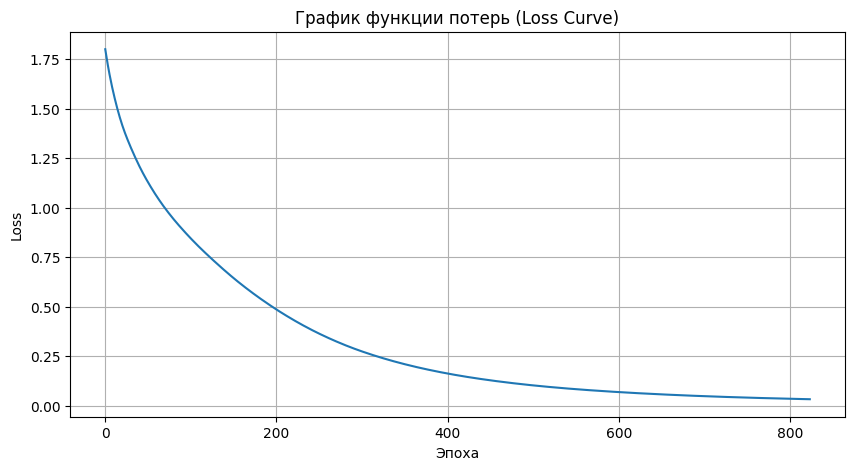

In [11]:
# Вывод графика
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Создание модели с лучшими параметрами
best_model = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    max_iter=1500,
    random_state=42
)

# Обучение модели с выводом 
history = best_model.fit(X_norm, y)

# можно отобразить loss_curve_
plt.figure(figsize=(10, 5))
plt.plot(best_model.loss_curve_)
plt.title("График функции потерь (Loss Curve)")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


# Обучение сети на сортированных данных

In [12]:

#Сортировка файла
import pandas as pd
# Загрузим оригинальные данные
df = pd.read_excel("data/Data_Set_(A+B).xlsx")

# Сортируем по целевой переменной (Type)
df_sorted = df.sort_values(by="Type").reset_index(drop=True)

# Сохраним как отдельный файл (опционально)
df_sorted.to_excel("data/Data_Set_Train_(Sort).xlsx", index=False)


In [13]:
# Загрузка обучающего датасета
df = pd.read_excel("data/Data_Set_Train_(Sort).xlsx")
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Отделим признаки и целевую переменную
X = df.drop("Type", axis=1)
y = df["Type"]

# Масштабируем признаки
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
import numpy as np

# Углы
theta = np.pi / 6  # 30 градусов в радианах
alpha = 0          # считаем что ориентирован

# Матрица преобразования
T = np.array([
    [-2/3 * np.cos(alpha - theta), 2/3 * np.sin(alpha),     2/3 * np.cos(alpha + theta)],
    [-2/3 * np.sin(alpha - theta), -2/3 * np.cos(alpha),    2/3 * np.sin(alpha + theta)],
    [1/3,                         1/3,                     1/3]
])

# Применяем к каждому ряду обучающей выборки
I = df[['I1', 'I2', 'I3']].values.T
V2 = T @ I  # матричное умножение

# Добавим Ix, Iy, Iphi в датафрейм
df['Ix'] = V2[0]
df['Iy'] = V2[1]
df['Iphi'] = V2[2]
df['Isum'] = V2[0] + V2[1] + V2[2]
# Геометрические параметры робота (похож на роботино?)
R = 0.04  # радиус колеса (м)
L = 0.125  # расстояние до центра (м)
theta = np.pi / 6  # 30 градусов в радианах
# Матрица преобразования для кинематических скоростей
T_vel = np.array([
    [-2/3 * np.cos(alpha - theta), 2/3 * np.cos(alpha),     2/3 * np.cos(alpha + theta)],
    [-2/3 * np.sin(alpha - theta), 2/3 * np.sin(alpha),     2/3 * np.sin(alpha + theta)],
    [1/(3*L),                     1/(3*L),                 1/(3*L)]
])

# Собираем угловые скорости
W = df[['V1real', 'V2real', 'V3real']].values.T  # (3, N)
V_xyz = R * T_vel @ W  # (3, N)

# Добавляем в датафрейм
df['Vx'] = V_xyz[0]
df['Vy'] = V_xyz[1]
df['Omega'] = V_xyz[2]
# Поиск лучших параметров
if False: # отключил перебор, зачем его просто так вызывать?
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import StratifiedKFold, cross_val_predict
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
    import itertools
    import numpy as np
    
    # Параметры для перебора
    hidden_layers = [(20,), (50, 20), (30, 30), (100,)]
    activations = ['relu', 'tanh', 'logistic']
    solvers = ['adam', 'lbfgs']
    max_iters = [1500, 3000]
    
    param_grid = list(itertools.product(hidden_layers, activations, solvers, max_iters))
    results = []
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for hl, act, sol, iters in param_grid:
        mlp = MLPClassifier(
            hidden_layer_sizes=hl,
            activation=act,
            solver=sol,
            max_iter=iters,
            random_state=42
        )
        try:
            y_pred = cross_val_predict(mlp, X_norm, y, cv=cv)
            acc = accuracy_score(y, y_pred)
            f1 = f1_score(y, y_pred, average='weighted')
            precision = precision_score(y, y_pred, labels=[3], average='macro', zero_division=0)
            recall = recall_score(y, y_pred, labels=[3], average='macro', zero_division=0)
            results.append(((hl, act, sol, iters), acc, f1, precision, recall))
            print(f"{hl}, {act}, {sol}, {iters} -> acc: {acc:.3f}, f1: {f1:.3f}, точн(3): {precision:.3f}, полн(3): {recall:.3f}")
        except Exception as e:
            print(f"{hl}, {act}, {sol}, {iters} -> ошибка: {e}")
    
    # Сортировка по f
    results.sort(key=lambda x: -x[2])
    
    print("\n Лучшая комбинация по F:")
    best = results[0]
    print(f"Параметры: {best[0]}")
    print(f"Accuracy: {best[1]:.3f}, F: {best[2]:.3f}")
    print(f"Точность по классу 3: {best[3]:.3f}")
    print(f"Полнота по классу 3: {best[4]:.3f}")
print("\n Лучшая комбинация по F: перебор закончен")


 Лучшая комбинация по F: перебор закончен


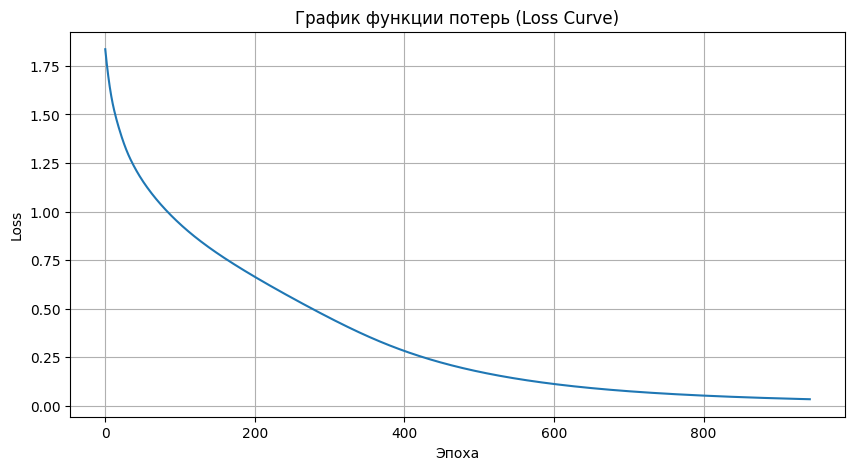

In [14]:
# Вывод графика
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Создание модели с лучшими параметрами
best_model = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='tanh',
    solver='adam',
    max_iter=1500,
    random_state=42
)

# Обучение модели с выводом 
history = best_model.fit(X_norm, y)

# можно отобразить loss_curve_
plt.figure(figsize=(10, 5))
plt.plot(best_model.loss_curve_)
plt.title("График функции потерь (Loss Curve)")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Обучение сети на нормализованных данных

In [15]:
# Загрузка обучающего датасета
import pandas as pd
df = pd.read_excel("data/Data_Set_Train_(Sort).xlsx")
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Отделим признаки и целевую переменную
X = df.drop("Type", axis=1)
y = df["Type"]

# Масштабируем признаки
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
import numpy as np

# Углы
theta = np.pi / 6  # 30 градусов в радианах
alpha = 0          # считаем что ориентирован

# Матрица преобразования
T = np.array([
    [-2/3 * np.cos(alpha - theta), 2/3 * np.sin(alpha),     2/3 * np.cos(alpha + theta)],
    [-2/3 * np.sin(alpha - theta), -2/3 * np.cos(alpha),    2/3 * np.sin(alpha + theta)],
    [1/3,                         1/3,                     1/3]
])

# Применяем к каждому ряду обучающей выборки
I = df[['I1', 'I2', 'I3']].values.T
V2 = T @ I  # матричное умножение

# Добавим Ix, Iy, Iphi в датафрейм
df['Ix'] = V2[0]
df['Iy'] = V2[1]
df['Iphi'] = V2[2]
df['Isum'] = V2[0] + V2[1] + V2[2]
# Геометрические параметры робота (похож на роботино?)
R = 0.04  # радиус колеса (м)
L = 0.125  # расстояние до центра (м)
theta = np.pi / 6  # 30 градусов в радианах
# Матрица преобразования для кинематических скоростей
T_vel = np.array([
    [-2/3 * np.cos(alpha - theta), 2/3 * np.cos(alpha),     2/3 * np.cos(alpha + theta)],
    [-2/3 * np.sin(alpha - theta), 2/3 * np.sin(alpha),     2/3 * np.sin(alpha + theta)],
    [1/(3*L),                     1/(3*L),                 1/(3*L)]
])

# Собираем угловые скорости
W = df[['V1real', 'V2real', 'V3real']].values.T  # (3, N)
V_xyz = R * T_vel @ W  # (3, N)

# Добавляем в датафрейм
df['Vx'] = V_xyz[0]
df['Vy'] = V_xyz[1]
df['Omega'] = V_xyz[2]

In [16]:
# Применение MinMax нормализации
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_Norm = scaler.fit_transform(X)

In [17]:
# Поиск лучших параметров
if False: # отключил перебор, зачем его просто так вызывать?
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import StratifiedKFold, cross_val_predict
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
    import itertools
    import numpy as np
    
    # Параметры для перебора
    hidden_layers = [(20,), (50, 20), (30, 30), (100,)]
    activations = ['relu', 'tanh', 'logistic']
    solvers = ['adam', 'lbfgs']
    max_iters = [1500, 3000]
    
    param_grid = list(itertools.product(hidden_layers, activations, solvers, max_iters))
    results = []
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for hl, act, sol, iters in param_grid:
        mlp = MLPClassifier(
            hidden_layer_sizes=hl,
            activation=act,
            solver=sol,
            max_iter=iters,
            random_state=42
        )
        try:
            y_pred = cross_val_predict(mlp, X_Norm, y, cv=cv)
            acc = accuracy_score(y, y_pred)
            f1 = f1_score(y, y_pred, average='weighted')
            precision = precision_score(y, y_pred, labels=[3], average='macro', zero_division=0)
            recall = recall_score(y, y_pred, labels=[3], average='macro', zero_division=0)
            results.append(((hl, act, sol, iters), acc, f1, precision, recall))
            print(f"{hl}, {act}, {sol}, {iters} -> acc: {acc:.3f}, f1: {f1:.3f}, точн(3): {precision:.3f}, полн(3): {recall:.3f}")
        except Exception as e:
            print(f"{hl}, {act}, {sol}, {iters} -> ошибка: {e}")
    
    # Сортировка по f
    results.sort(key=lambda x: -x[2])
    
    print("\n Лучшая комбинация по F:")
    best = results[0]
    print(f"Параметры: {best[0]}")
    print(f"Accuracy: {best[1]:.3f}, F: {best[2]:.3f}")
    print(f"Точность по классу 3: {best[3]:.3f}")
    print(f"Полнота по классу 3: {best[4]:.3f}")
print("\n Лучшая комбинация по F: перебор закончен")


 Лучшая комбинация по F: перебор закончен


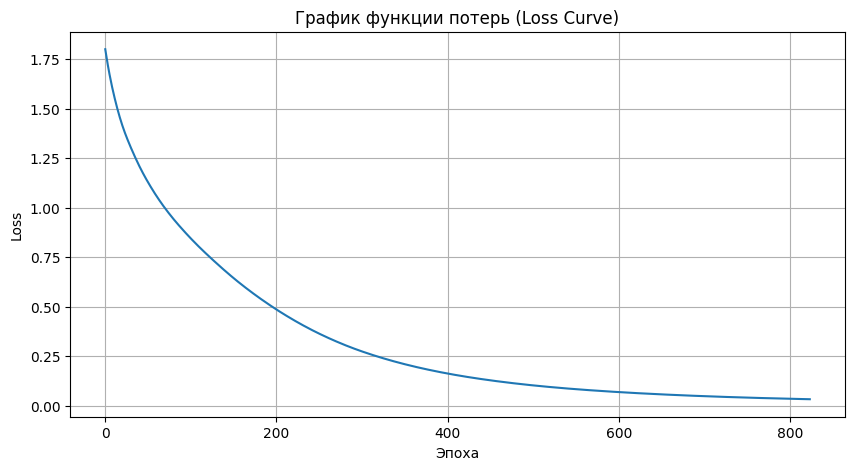

In [18]:
# Вывод графика
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Создание модели с лучшими параметрами
best_model = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    max_iter=3000,
    random_state=42
)

# Обучение модели с выводом 
history = best_model.fit(X_norm, y)

# можно отобразить loss_curve_
plt.figure(figsize=(10, 5))
plt.plot(best_model.loss_curve_)
plt.title("График функции потерь (Loss Curve)")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Обучение сети на сбалансированных данных

In [20]:
# Загрузка обучающего датасета
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE  # Добавлено для балансировки

df = pd.read_excel("data/Data_Set_Train_(Sort).xlsx")

# Отделим признаки и целевую переменную
X = df.drop("Type", axis=1)
y = df["Type"]

# Масштабируем признаки
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

# Углы
theta = np.pi / 6  # 30 градусов в радианах
alpha = 0          # считаем что ориентирован

# Матрица преобразования
T = np.array([
    [-2/3 * np.cos(alpha - theta), 2/3 * np.sin(alpha),     2/3 * np.cos(alpha + theta)],
    [-2/3 * np.sin(alpha - theta), -2/3 * np.cos(alpha),    2/3 * np.sin(alpha + theta)],
    [1/3,                          1/3,                     1/3]
])

# Применяем к каждому ряду обучающей выборки
I = df[['I1', 'I2', 'I3']].values.T
V2 = T @ I  # матричное умножение

# Добавим Ix, Iy, Iphi в датафрейм
df['Ix'] = V2[0]
df['Iy'] = V2[1]
df['Iphi'] = V2[2]
df['Isum'] = V2[0] + V2[1] + V2[2]

# Геометрические параметры робота
R = 0.04  # радиус колеса (м)
L = 0.125  # расстояние до центра (м)

# Матрица преобразования для кинематических скоростей
T_vel = np.array([
    [-2/3 * np.cos(alpha - theta),  2/3 * np.cos(alpha),      2/3 * np.cos(alpha + theta)],
    [-2/3 * np.sin(alpha - theta),  2/3 * np.sin(alpha),      2/3 * np.sin(alpha + theta)],
    [1/(3*L),                       1/(3*L),                  1/(3*L)]
])

# Собираем угловые скорости
W = df[['V1real', 'V2real', 'V3real']].values.T
V_xyz = R * T_vel @ W

# Добавляем в датафрейм
df['Vx'] = V_xyz[0]
df['Vy'] = V_xyz[1]
df['Omega'] = V_xyz[2]

# Балансировка данных
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_norm, y)  #


In [33]:
# Поиск лучших параметров
if False: # отключил перебор, зачем его просто так вызывать?
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import StratifiedKFold, cross_val_predict
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
    import itertools
    import numpy as np
    
    # Параметры для перебора
    hidden_layers = [(20,), (50, 20), (30, 30), (100,)]
    activations = ['relu', 'tanh', 'logistic']
    solvers = ['adam', 'lbfgs']
    max_iters = [1500, 3000]
    
    param_grid = list(itertools.product(hidden_layers, activations, solvers, max_iters))
    results = []
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for hl, act, sol, iters in param_grid:
        mlp = MLPClassifier(
            hidden_layer_sizes=hl,
            activation=act,
            solver=sol,
            max_iter=iters,
            random_state=42
        )
        try:
            y_pred = cross_val_predict(mlp, X_bal, y_bal, cv=cv)
            acc = accuracy_score(y_bal, y_pred)
            f1 = f1_score(y_bal, y_pred, average='weighted')
            precision = precision_score(y_bal, y_pred, labels=[3], average='macro', zero_division=0)
            recall = recall_score(y_bal, y_pred, labels=[3], average='macro', zero_division=0)
            results.append(((hl, act, sol, iters), acc, f1, precision, recall))
            print(f"{hl}, {act}, {sol}, {iters} -> acc: {acc:.3f}, f1: {f1:.3f}, точн(3): {precision:.3f}, полн(3): {recall:.3f}")
        except Exception as e:
            print(f"{hl}, {act}, {sol}, {iters} -> ошибка: {e}")
    
    # Сортировка по f
    results.sort(key=lambda x: -x[2])
    
    print("\n Лучшая комбинация по F:")
    best = results[0]
    print(f"Параметры: {best[0]}")
    print(f"Accuracy: {best[1]:.3f}, F: {best[2]:.3f}")
    print(f"Точность по классу 3: {best[3]:.3f}")
    print(f"Полнота по классу 3: {best[4]:.3f}")
print("\n Лучшая комбинация по F: перебор закончен")


 Лучшая комбинация по F: перебор закончен


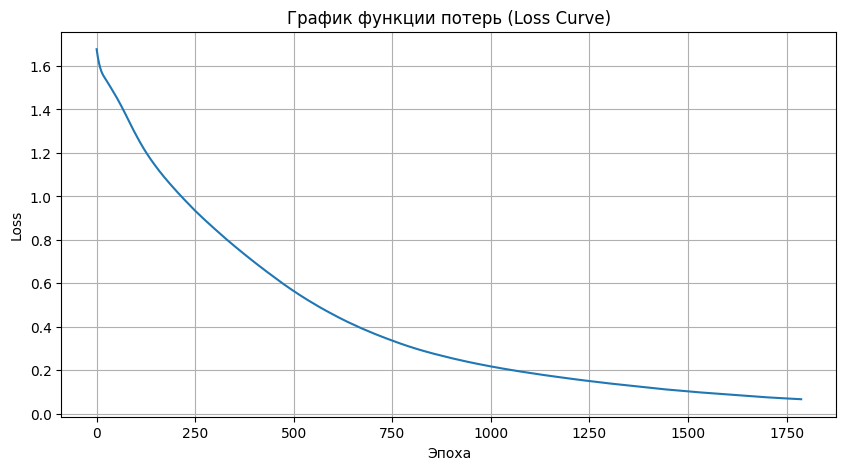

In [24]:
# Вывод графика
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Создание модели с лучшими параметрами
best_model = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    max_iter=3000,
    random_state=42
)

# Обучение модели с выводом 
history = best_model.fit(X_bal, y_bal)

# можно отобразить loss_curve_
plt.figure(figsize=(10, 5))
plt.plot(best_model.loss_curve_)
plt.title("График функции потерь (Loss Curve)")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Проверка сети на контрольной выборке C

In [31]:
# Загрузка выборки C

import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score

# Загрузка данных
df_C = pd.read_excel("data/Data_Set_C.xlsx")

# Вычисления абсолютных параметров
theta = np.pi / 6
alpha = 0

T = np.array([
    [-2/3 * np.cos(alpha - theta), 2/3 * np.sin(alpha),     2/3 * np.cos(alpha + theta)],
    [-2/3 * np.sin(alpha - theta), -2/3 * np.cos(alpha),    2/3 * np.sin(alpha + theta)],
    [1/3,                         1/3,                     1/3]
])

I = df_C[['I1', 'I2', 'I3']].values.T
V2 = T @ I
df_C['Ix'] = V2[0]
df_C['Iy'] = V2[1]
df_C['Iphi'] = V2[2]
df_C['Isum'] = V2[0] + V2[1] + V2[2]

# Скорости
R = 0.04
L = 0.125
T_vel = np.array([
    [-2/3 * np.cos(alpha - theta), 2/3 * np.cos(alpha),     2/3 * np.cos(alpha + theta)],
    [-2/3 * np.sin(alpha - theta), 2/3 * np.sin(alpha),     2/3 * np.sin(alpha + theta)],
    [1/(3*L),                     1/(3*L),                 1/(3*L)]
])

W = df_C[['V1real', 'V2real', 'V3real']].values.T
V_xyz = R * T_vel @ W
df_C['Vx'] = V_xyz[0]
df_C['Vy'] = V_xyz[1]
df_C['Omega'] = V_xyz[2]

# Признаки и метки
y_C = df_C["Type"]
X_C = df_C[X.columns]  # используем только те же признаки, что были при обучении
X_C_norm = scaler.transform(X_C)

# Приводим X_C к тем же признакам, что были в X (X_bal создавался из X)
X_C = X.columns.intersection(df_C.columns)  # выбираем нужные признаки
X_C = df_C[X_C]  # применяем порядок и состав
X_C_norm = scaler.transform(X_C)

trained_classifiers = []
# Приведение к масштабу обучающей выборки
X_C_norm = scaler.transform(X_C)

# Предсказания по трем моделям с заданными параметрами
model_params = [
    ((50, 20), 'relu', 'adam', 1500),
    ((50, 20), 'tanh', 'adam', 3000),
    ((100,), 'relu', 'adam', 1500)
]

for idx, params in enumerate(model_params):
    clf = MLPClassifier(
        hidden_layer_sizes=params[0],
        activation=params[1],
        solver=params[2],
        max_iter=params[3],
        random_state=42
    )
    
    clf.fit(X_bal, y_bal)
    trained_classifiers.append(clf)
    y_pred = clf.predict(X_C_norm)
    
    acc = accuracy_score(y_C, y_pred)
    f1 = f1_score(y_C, y_pred, average='weighted')
    print(f"\nМодель {idx+1}: {params}")
    print(f"Accuracy = {acc:.3f}, F1 = {f1:.3f}")



Модель 1: ((50, 20), 'relu', 'adam', 1500)
Accuracy = 0.793, F1 = 0.789

Модель 2: ((50, 20), 'tanh', 'adam', 3000)
Accuracy = 0.845, F1 = 0.845

Модель 3: ((100,), 'relu', 'adam', 1500)
Accuracy = 0.810, F1 = 0.805


C:\Users\Admin\anaconda3\envs\ML_lab2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


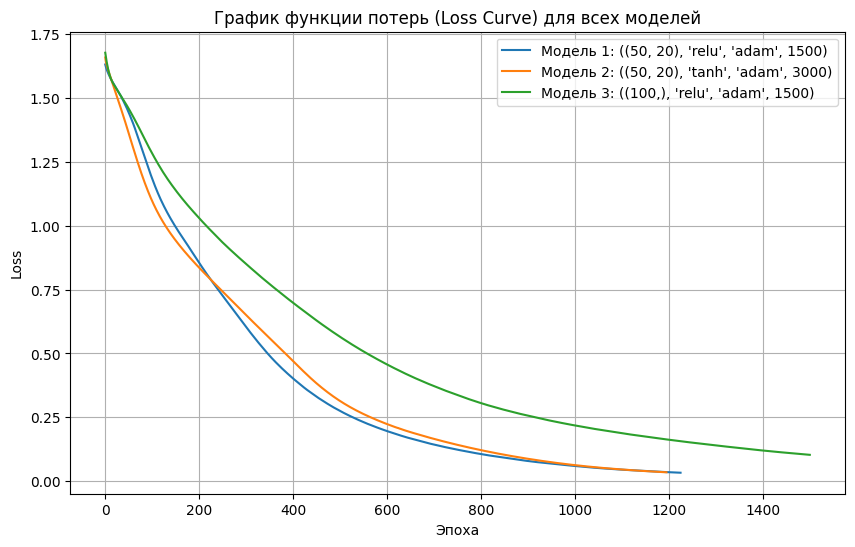

In [34]:
import matplotlib.pyplot as plt

# Построение графика функции потерь для всех трёх моделей
plt.figure(figsize=(10, 6))

for idx, clf in enumerate(trained_classifiers):
    if hasattr(clf, "loss_curve_"):
        plt.plot(clf.loss_curve_, label=f"Модель {idx+1}: {model_params[idx]}")

plt.title("График функции потерь (Loss Curve) для всех моделей")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


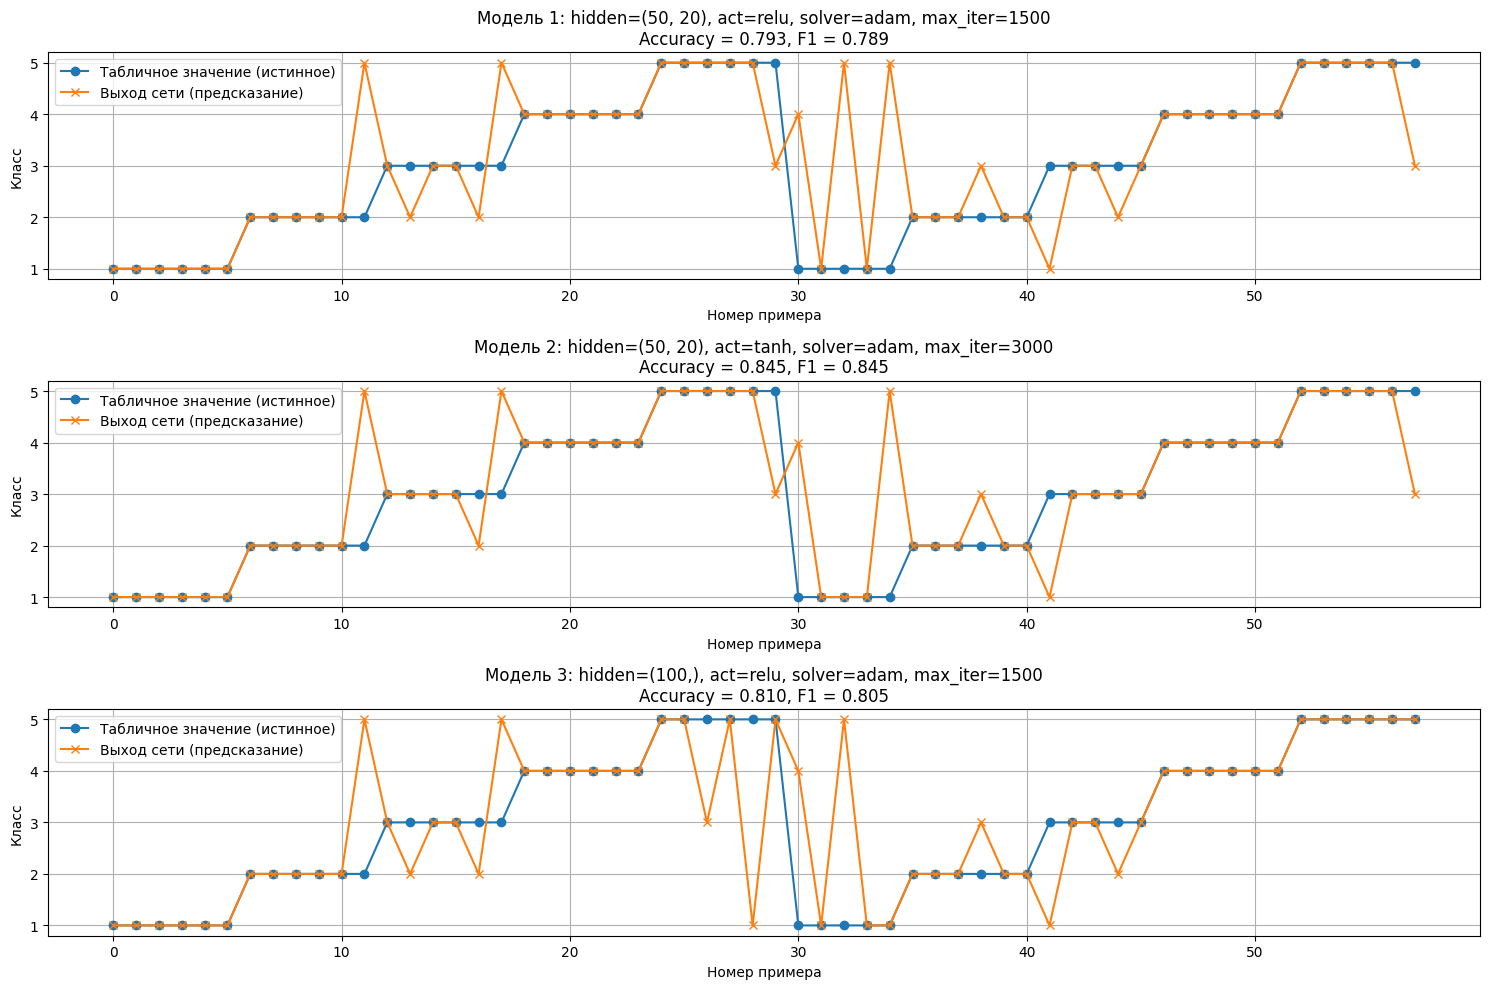

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# Параметры моделей и список предсказаний
model_params = [
    ((50, 20), 'relu', 'adam', 1500),
    ((50, 20), 'tanh', 'adam', 3000),
    ((100,), 'relu', 'adam', 1500)
]

plt.figure(figsize=(15, 10))

for idx, clf in enumerate(trained_classifiers):
    y_pred = clf.predict(X_C_norm)
    acc = accuracy_score(y_C, y_pred)
    f1 = f1_score(y_C, y_pred, average='weighted')

    # Строим график
    plt.subplot(3, 1, idx + 1)
    plt.plot(y_C.values, label="Табличное значение (истинное)", marker='o')
    plt.plot(y_pred, label="Выход сети (предсказание)", marker='x')
    plt.title(f"Модель {idx+1}: hidden={model_params[idx][0]}, act={model_params[idx][1]}, "
              f"solver={model_params[idx][2]}, max_iter={model_params[idx][3]}\n"
              f"Accuracy = {acc:.3f}, F1 = {f1:.3f}")
    plt.xlabel("Номер примера")
    plt.ylabel("Класс")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


# Подготовка к выборке D

In [36]:
# Объединение данных B+C
X_combined = pd.concat([pd.DataFrame(X_bal, columns=X.columns), X_C], ignore_index=True)
y_combined = pd.concat([pd.Series(y_bal), y_C], ignore_index=True)

# Нормализация с тем же скейлером
X_combined_norm = scaler.transform(X_combined)

# Модель 2: (50, 20), 'tanh', 'adam', 3000
clf2_updated = MLPClassifier(
    hidden_layer_sizes=(50, 20),
    activation='tanh',
    solver='adam',
    max_iter=3000,
    random_state=42
)

clf2_updated.fit(X_combined_norm, y_combined)

# Загрузка данных
df_D = pd.read_excel("data/Data_Set_D.xlsx")

# Вычисление параметров как обычно
I = df_D[['I1', 'I2', 'I3']].values.T
V2 = T @ I
df_D['Ix'] = V2[0]
df_D['Iy'] = V2[1]
df_D['Iphi'] = V2[2]
df_D['Isum'] = V2[0] + V2[1] + V2[2]

W = df_D[['V1real', 'V2real', 'V3real']].values.T
V_xyz = R * T_vel @ W
df_D['Vx'] = V_xyz[0]
df_D['Vy'] = V_xyz[1]
df_D['Omega'] = V_xyz[2]

# Формируем X_D и y_D
X_D = X.columns.intersection(df_D.columns)  # выбираем нужные признаки
X_C = df_D[X_D]  # применяем порядок и состав
y_D = df_D["Type"]

# Нормализация
X_D_norm = scaler.transform(X_D)

from sklearn.metrics import accuracy_score, f1_score

y_D_pred = clf2_updated.predict(X_D_norm)
acc_D = accuracy_score(y_D, y_D_pred)
f1_D = f1_score(y_D, y_D_pred, average='weighted')

print(f"Проверка на выборке D (Модель 2 дообучена на C):")
print(f"Accuracy = {acc_D:.3f}")
print(f"F1-score = {f1_D:.3f}")
